# Memory tracking

In [16]:
import sys, os, math, random
sys.path.append(os.environ['HOME']+'/git0/pixel-cnn-private/pixel_cnn_pp/tests')
sys.path.append(os.environ['HOME']+'/git0/pixel-cnn-private/pixel_cnn_pp')
os.environ['CUDA_VISIBLE_DEVICES']='1'

import memory_util
memory_util.vlog(1)   # vlog=2 on GPU machine will hang

import tensorflow as tf
import tensorflow.contrib   # takes 15 seconds
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

def create_session():
    config = tf.ConfigProto(operation_timeout_in_ms=50000, log_device_placement=False,graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    return tf.InteractiveSession(config=config)
    
import importlib
importlib.reload(memory_util)

#from pixel_cnn_pp.memory_saving_gradients import gradients as smart_gradients

<module 'memory_util' from '/home/yaroslav/git0/pixel-cnn-private/pixel_cnn_pp/memory_util.py'>

In [17]:
import os, sys
import numpy as np
import time
import tensorflow as tf
import traceback
#import resnet_model
import networkx as nx

from collections import Counter

# from https://github.com/yaroslavvb/notebooks/blob/master/simple_rewiring.ipynb
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [18]:
tf.reset_default_graph()
node_mbs = 1
length = 5

dtype = np.float32
n = node_mbs * 250000
a0_ = tf.ones((n,), dtype=dtype)
a0 = tf.Variable(a0_, name="a0")
a = a0
for i in range(1, length):
    name = "a"+str(i)
    a = tf.tanh(a, name=name)

grad = tf.gradients([a], [a0])[0]
sess = create_session()

sess.run(tf.global_variables_initializer())
with memory_util.capture_stderr() as stderr:
    sess.run(grad.op)
memory_util.print_memory_timeline(stderr.getvalue())

        6              gradients/Const(27-GPU_0_bfc)         256         256 GPU_0_bfc
       17               gradients/Fill(28-GPU_0_bfc)     1000192     1000448 GPU_0_bfc
       19   gradients/a1_grad/TanhGrad(29-GPU_0_bfc)     1000192     2000640 GPU_0_bfc
       21   gradients/a2_grad/TanhGrad(30-GPU_0_bfc)     1000192     3000832 GPU_0_bfc
       23   gradients/a3_grad/TanhGrad(31-GPU_0_bfc)     1000192     4001024 GPU_0_bfc
       25   gradients/a4_grad/TanhGrad(32-GPU_0_bfc)     1000192     5001216 GPU_0_bfc
       28               gradients/Fill(28-GPU_0_bfc)    -1000192     4001024 GPU_0_bfc
       30   gradients/a4_grad/TanhGrad(32-GPU_0_bfc)    -1000192     3000832 GPU_0_bfc
       32   gradients/a3_grad/TanhGrad(31-GPU_0_bfc)    -1000192     2000640 GPU_0_bfc
       34   gradients/a2_grad/TanhGrad(30-GPU_0_bfc)    -1000192     1000448 GPU_0_bfc
       35   gradients/a1_grad/TanhGrad(29-GPU_0_bfc)    -1000192         256 GPU_0_bfc


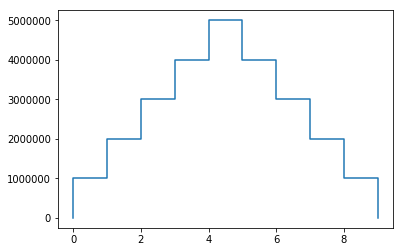

In [19]:
memory_util.plot_memory_timeline(stderr.getvalue())

In [20]:
def make_resnet_with_memstats(length=100, name_prefix="a", node_mbs=1):
  """Creates resnet-like chain of length length. First node is constant,
  rest are tanh.  Returns list of nodes. Has length - 2 articulation points (ie 
  for length=3 there is 1 articulation point."""

  dtype = np.float32
  n = node_mbs * 250000
  a0 = tf.ones((n,), dtype=dtype, name=name_prefix+"00")
  a = a0
  nodes = [a]
  memstat_nodes = []
  for i in range(1, length):
    with tf.control_dependencies([nodes[-1]]):
      memstat_node = tf.contrib.memory_stats.MaxBytesInUse()
      memstat_nodes.append(memstat_node)
    name = "%s%02d"%(name_prefix, i)
    with tf.control_dependencies([memstat_node]):
      a_nonlin = tf.tanh(a, name=name+"_tanh")
    a = tf.add(a, a_nonlin, name=name+"_add")
    nodes.append(a)
    
  return nodes, memstat_nodes


def make_resnet_dual_gpu(length=10, name_prefix="a", node_mbs=1):
  """Creates resnet-like chain of length length. First node is constant,
  rest are tanh.  Returns list of nodes. Has length - 2 articulation points (ie 
  for length=3 there is 1 articulation point."""

  dtype = np.float32
  n = node_mbs * 250000
  a0 = tf.ones((n,), dtype=dtype, name=name_prefix+"00")
  a = a0
  nodes = [a]
  for i in range(1, length):
    with tf.device("/gpu:"+str(i%2)):
      name = "%s%02d"%(name_prefix, i)
      a_nonlin = tf.tanh(a, name=name+"_tanh")
      a = tf.add(a, a_nonlin, name=name+"_add")
    nodes.append(a)
    
  return nodes


In [38]:
tf.reset_default_graph()
sess = create_session()
n = 10
nodes, memstat_nodes = make_resnet_with_memstats(n)
a0 = nodes[0]
a = nodes[-1]
with tf.control_dependencies([a]):
    grad = tf.gradients([a], [a0])[0]
with tf.control_dependencies([grad]):
    memstat_nodes.append(tf.contrib.memory_stats.MaxBytesInUse())
    
run_metadata = tf.RunMetadata()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)

with memory_util.capture_stderr() as stderr:
    _, memstat_nodes0 = sess.run([grad.op, memstat_nodes], options=run_options, run_metadata=run_metadata)

In [7]:
memory_util.print_memory_timeline(stderr.getvalue())

        3                          a00(11-GPU_0_bfc)     1000192     1000192 GPU_0_bfc
       11              gradients/Const(12-GPU_0_bfc)         256     1000448 GPU_0_bfc
       71            MaxBytesInUse_9/_19(1-cpu_pool)           8     1000456 cpu_pool
       74 gradients/a01_tanh_grad/TanhGrad(13-GPU_0_bfc)     1000192     2000648 GPU_0_bfc
       76                      a09_add(14-GPU_0_bfc)     1000192     3000840 GPU_0_bfc
       78            MaxBytesInUse_9/_19(1-cpu_pool)           8     3000848 cpu_pool
       81 gradients/a02_tanh_grad/TanhGrad(15-GPU_0_bfc)     1000192     4001040 GPU_0_bfc
       84            MaxBytesInUse_9/_19(1-cpu_pool)           8     4001048 cpu_pool
       87 gradients/a03_tanh_grad/TanhGrad(16-GPU_0_bfc)     1000192     5001240 GPU_0_bfc
       90            MaxBytesInUse_9/_19(1-cpu_pool)           8     5001248 cpu_pool
       93 gradients/a04_tanh_grad/TanhGrad(17-GPU_0_bfc)     1000192     6001440 GPU_0_bfc
       96            MaxBytesIn

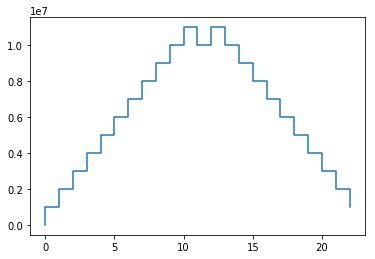

In [8]:
memory_util.plot_memory_timeline(stderr.getvalue())

In [58]:
dev_stat = run_metadata.step_stats.dev_stats[1]
node_stat = dev_stat.node_stats[7]

In [59]:
node_stat

node_name: "a02_add"
all_start_micros: 1505768360742529
op_start_rel_micros: 32
op_end_rel_micros: 80
all_end_rel_micros: 137
memory {
  allocator_name: "GPU_0_bfc"
  allocator_bytes_in_use: 171016448
}
output {
  tensor_description {
    dtype: DT_FLOAT
    shape {
      dim {
        size: 250000
      }
    }
    allocation_description {
      requested_bytes: 1000000
      allocated_bytes: 1000192
      allocator_name: "GPU_0_bfc"
      allocation_id: 3735
      ptr: 1108455317760
    }
  }
}
timeline_label: "a02_add = Add(a01_add, a02_tanh)"
scheduled_micros: 1505768360742492
memory_stats {
}

In [22]:
def memory_timeline_dict(run_metadata):
#            timestamp, kernel_name, allocated_bytes, allocator_type, total = record

    result = {}
    for dev_stat in run_metadata.step_stats.dev_stats:
        result[dev_stat.device] = memory_timeline_from_devstats(dev_stat)
    return result

In [23]:
def memory_timeline_from_devstats(dev_stat):
    """Takes DeviceStepStats, produces memory timeline."""
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/step_stats.proto#L65
    result = []
    for node_stat in dev_stat.node_stats:
        memory = -12345
        for memory_stat in node_stat.memory:
            # sometimes get multiple allocators involved, ignore CPU allocators
    #             gradients/a09_add_grad/BroadcastGradientArgs [allocator_name: "GPU_0_bfc"
    #allocator_bytes_in_use: 4007936
    #, allocator_name: "cpu_pool"
    #]
            if not memory_stat.allocator_bytes_in_use:
                continue
            else:
                memory = memory_stat.allocator_bytes_in_use
        result.append([node_stat.all_start_micros, node_stat.node_name, memory])
    return result

In [24]:
memory_timeline_dict(run_metadata)

{'/device:GPU:0/stream:13': [[1505766531585786, 'a01_tanh:Tanh', -12345],
  [1505766531586105, 'a01_add:Add', -12345],
  [1505766531586837, 'a02_tanh:Tanh', -12345],
  [1505766531587070, 'a02_add:Add', -12345],
  [1505766531587759, 'a03_tanh:Tanh', -12345],
  [1505766531587971, 'a03_add:Add', -12345],
  [1505766531588680, 'a04_tanh:Tanh', -12345],
  [1505766531588922, 'a04_add:Add', -12345],
  [1505766531589609, 'a05_tanh:Tanh', -12345],
  [1505766531589839, 'a05_add:Add', -12345],
  [1505766531590537, 'a06_tanh:Tanh', -12345],
  [1505766531590778, 'a06_add:Add', -12345],
  [1505766531591488, 'a07_tanh:Tanh', -12345],
  [1505766531591723, 'a07_add:Add', -12345],
  [1505766531592475, 'a08_tanh:Tanh', -12345],
  [1505766531592714, 'a08_add:Add', -12345],
  [1505766531593429, 'a09_tanh:Tanh', -12345],
  [1505766531593630, 'a09_add:Add', -12345],
  [1505766531597779, 'gradients/Fill:Fill', -12345],
  [1505766531600450, 'gradients/a09_tanh_grad/TanhGrad:TanhGrad', -12345],
  [15057665316006

# Plot memory timeline for resnet

In [25]:
  import resnet_model
  tf.reset_default_graph()
  num_classes=10
  batch_size = 128
  mode = "train"
  sess = create_session()
  iters = 1
  warm_up_iters = 1
  num_batches = iters+warm_up_iters
  sess = create_session()

  images, labels = resnet_model.build_random_cifar10_input(batch_size, num_batches=num_batches, sess=sess)
  
  hps = resnet_model.HParams(batch_size=batch_size,
                             num_classes=num_classes,
                             min_lrn_rate=0.0001,
                             lrn_rate=0.1,
                             num_residual_units=5,
                             use_bottleneck=False,
                             weight_decay_rate=0.0002,
                             relu_leakiness=0.1,
                             optimizer='mom')
  model = resnet_model.ResNet(hps, images, labels, mode)
  model.build_graph()

  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())

  run_metadata = tf.RunMetadata()
  run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)

  sess.run(model.train_op, options=run_options, run_metadata=run_metadata)

Preloading cifar10 data
Loaded 256 examples
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Summary name learning rate is illegal; using learning_rate instead.


In [26]:
timeline_dict = memory_timeline_dict(run_metadata)

In [27]:
timeline_dict.keys()

dict_keys(['/device:GPU:0/stream:7', '/device:GPU:0/stream:14', '/job:localhost/replica:0/task:0/device:GPU:0', '/device:GPU:0/memcpy', '/device:GPU:0/stream:18', '/device:GPU:0/stream:all', '/device:GPU:0/stream:15', '/job:localhost/replica:0/task:0/cpu:0', '/device:GPU:0/stream:19', '/device:GPU:0/stream:13'])

In [28]:
def plot_memory_timeline(timeline):
# timestamp, nodename, memory
    timestamps = []
    plt.plot([record[0] for record in timeline], [record[2] for record in timeline])

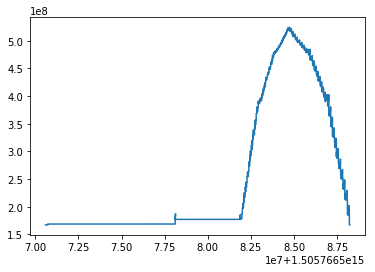

In [29]:
plot_memory_timeline(timeline_dict['/job:localhost/replica:0/task:0/device:GPU:0'])

# Analyze resnet

In [34]:
1+2

3

In [37]:
node_stat

node_name: "group_deps"
all_start_micros: 1505766588234096
op_start_rel_micros: 63
op_end_rel_micros: 79
all_end_rel_micros: 270
memory {
  allocator_name: "GPU_0_bfc"
  allocator_bytes_in_use: 167014144
}
timeline_label: "group_deps = NoOp(^train_step/_1041, ^unit_1_0/shared_activation/init_bn/AssignMovingAvg, ^unit_1_0/shared_activation/init_bn/AssignMovingAvg_1, ^unit_1_0/sub2/bn2/AssignMovingAvg, ^unit_1_0/sub2/bn2/AssignMovingAvg_1, ^unit_1_1/residual_only_activation/init_bn/AssignMovingAvg, ^unit_1_1/residual_only_activation/init_bn/AssignMovingAvg_1, ^unit_1_1/sub2/bn2/AssignMovingAvg, ^unit_1_1/sub2/bn2/AssignMovingAvg_1, ^unit_1_2/residual_only_activation/init_bn/AssignMovingAvg, ^unit_1_2/residual_only_activation/init_bn/AssignMovingAvg_1, ^unit_1_2/sub2/bn2/AssignMovingAvg, ^unit_1_2/sub2/bn2/AssignMovingAvg_1, ^unit_1_3/residual_only_activation/init_bn/AssignMovingAvg, ^unit_1_3/residual_only_activation/init_bn/AssignMovingAvg_1, ^unit_1_3/sub2/bn2/AssignMovingAvg, ^unit_1_

In [36]:
# find critical path for memory allocations
peak_memory = 0

dev_stat = None
for dev_stat0 in run_metadata.step_stats.dev_stats:
    if '/job:localhost/replica:0/task:0/device:GPU' in dev_stat0.device:
        assert not dev_stat, "multiple GPU stats?"
        dev_stat = dev_stat0
        break
assert dev_stat, "No GPU device stats found"

for node_stat in dev_stat.node_stats:
    for node_stat in dev_stat.node_stats:
        memory = -12345
        for memory_stat in node_stat.memory:
            if not memory_stat.allocator_bytes_in_use:
                continue
            else:
                memory = memory_stat.allocator_bytes_in_use
        if memory > peak_memory:
            print(node_stat.node_name, memory)
            peak_memory = memory

_SOURCE 167014144
unit_1_0/sub2/mul/x 168587008
gradients/Fill 168587264
gradients/costs/Mul_grad/BroadcastGradientArgs 168587520
gradients/unit_last/Mean_grad/add 168587776
gradients/unit_last/Mean_grad/Fill 168588032
gradients/unit_last/mul_grad/BroadcastGradientArgs 168588288
gradients/costs/xent_grad/floordiv 168588544
gradients/unit_last/final_bn/moments/SquaredDifference_grad/BroadcastGradientArgs 168588800
gradients/unit_last/final_bn/moments/mean_grad/add 168589312
gradients/unit_last/final_bn/moments/mean_grad/Prod 168589824
gradients/unit_3_4/sub2/bn2/moments/mean_grad/add 168590592
gradients/unit_3_4/sub2/bn2/moments/mean_grad/Prod_1 168590848
gradients/unit_3_4/residual_only_activation/init_bn/moments/mean_grad/add 168591104
gradients/unit_3_4/residual_only_activation/init_bn/moments/variance_grad/Prod 168591360
gradients/unit_3_4/residual_only_activation/init_bn/moments/mean_grad/Prod 168591616
gradients/unit_3_3/sub2/bn2/moments/SquaredDifference_grad/BroadcastGradientArg

# Caterpillar graph

In [ ]:
result = tf.random_uniform((size, size))
for i in range(n):
    result = result @ tf.random_uniform((size, size))